# Análise do Impacto dos Juros no Comportamento de Consumo  
## Integração de Dados Olist e Indicadores Macroeconômicos

Este notebook tem como objetivo investigar a relação entre variáveis macroeconômicas — 
em especial taxas de juros — e o comportamento de consumo observado na base de dados da Olist.

A análise será conduzida a partir da integração entre:

- Uma base de dados de **pedidos da Olist**, previamente tratada e agregada ao nível mensal,
  segmentada por **categoria dominante de produto** e restrita a compras realizadas via crédito;
- Uma base de **indicadores econômicos**, contendo informações sobre taxa Selic, inflação
  e custo real do crédito.

O foco do estudo é responder às seguintes questões:

- Existe correlação entre juros e valor dos pedidos ao longo do tempo?
- O uso do crédito (parcelamento) se altera conforme o nível de juros?
- Há evidência de defasagem temporal (*lag*) entre alterações nos juros e o comportamento do consumidor?
- Quais categorias de produtos demonstram maior sensibilidade às variações nas taxas de juros?

Este notebook parte de dados já explorados e tratados em uma etapa anterior, concentrando-se
exclusivamente na **análise integrada e interpretativa** entre consumo e macroeconomia.


In [6]:
# Ajuste de path para importar utilidades do projeto
import sys
from pathlib import Path

sys.path.append(str(Path.cwd().parent.parent))

# Bibliotecas principais
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Configuração visual padronizada do projeto
from utils.viz_config import PALETA_OLIST

# Configurações gerais
pd.set_option('display.max_columns', 100)
pd.set_option('display.float_format', '{:,.2f}'.format)

sns.set_theme(style="whitegrid")


## Importação das Bases de Dados

Serão carregadas duas bases principais:

1. **Base Olist tratada**, agregada mensalmente por categoria de produto dominante,
   contendo métricas de valor de pedido, volume de vendas e parcelamento.
2. **Base de indicadores macroeconômicos**, contendo informações sobre taxa de juros,
   inflação e custo real do crédito, também em frequência mensal.

Ambas as bases utilizam a coluna `Date` como chave temporal para posterior integração.


In [13]:


# Base Olist preparada para cruzamento macroeconômico
olist = pd.read_csv(
    '../../dados/olist_agregada_mes.csv',
    parse_dates=['Date']
)

# Base de indicadores macroeconômicos
macro = pd.read_csv(
    '../../dados/dados_economicos.csv',
    parse_dates=['Date']
)

# Visualização inicial
display(olist.head())
display(macro.head())


,Date,product_category_name,total_pedidos,ticket_medio,ticket_mediana,parcelas_media,parcelas_mediana,faturamento_total
0,2016-09-01,moveis_decoracao,1,72.89,72.89,1.00,1.00,72.89
1,2016-09-01,telefonia,1,59.50,59.50,3.00,3.00,59.50
2,2016-10-01,alimentos,1,79.90,79.90,1.00,1.00,79.90
3,2016-10-01,audio,1,132.00,132.00,3.00,3.00,132.00
4,2016-10-01,automotivo,10,182.32,106.75,4.60,4.00,"1,823.25"


,Date,juros_base_selic,previsao_inflacao_12m,inflacao_realizada_12m,custo_real_esperado,custo_real_efetivo,juros_base_selic_std,previsao_inflacao_12m_std,inflacao_realizada_12m_std,custo_real_esperado_std,custo_real_efetivo_std
0,2016-01-01,14.25,7.05,10.71,6.72,3.20,1.19,2.46,2.04,0.57,-0.86
1,2016-02-01,14.25,6.97,10.36,6.80,3.52,1.19,2.38,1.91,0.61,-0.68
2,2016-03-01,14.25,6.66,9.39,7.12,4.44,1.19,2.04,1.55,0.74,-0.17
3,2016-04-01,14.25,6.33,9.28,7.45,4.55,1.19,1.69,1.50,0.87,-0.12
4,2016-05-01,14.25,6.08,9.32,7.70,4.51,1.19,1.44,1.52,0.98,-0.14


## Verificação Estrutural

Antes da integração das bases, é importante validar:

- Intervalo temporal coberto por cada base;
- Consistência das colunas de data;
- Ausência de duplicidades inesperadas;
- Compatibilidade da frequência temporal (mensal).

Essa verificação evita erros silenciosos durante o cruzamento dos dados.


In [14]:
print('Base Olist')
print('Período:', olist['Date'].min(), '→', olist['Date'].max())
print('Observações:', len(olist))
print()

print('Base Macroeconômica')
print('Período:', macro['Date'].min(), '→', macro['Date'].max())
print('Observações:', len(macro))


Base Olist
Período: 2016-09-01 00:00:00 → 2018-08-01 00:00:00
Observações: 1224

Base Macroeconômica
Período: 2016-01-01 00:00:00 → 2018-12-01 00:00:00
Observações: 36


## Seleção das Taxas de Juros

A análise utilizará diferentes medidas de taxa de juros, explorando tanto o efeito
da política monetária quanto o custo real do crédito percebido pelo consumidor.

- **Juros base (Selic)**: utilizada como indicador macroeconômico, refletindo a
  orientação geral da política monetária.
- **Custo real esperado do crédito**: representa o custo real do dinheiro considerando
  expectativas inflacionárias, sendo a principal variável explicativa do comportamento
  de consumo.
- **Custo real efetivo**: utilizado como variável de controle e validação analítica.

Essa abordagem permite avaliar tanto efeitos imediatos quanto defasados das alterações
nas condições monetárias sobre o comportamento do consumidor.


In [15]:
macro.columns


Index(['Date', 'juros_base_selic', 'previsao_inflacao_12m',
       'inflacao_realizada_12m', 'custo_real_esperado', 'custo_real_efetivo',
       'juros_base_selic_std', 'previsao_inflacao_12m_std',
       'inflacao_realizada_12m_std', 'custo_real_esperado_std',
       'custo_real_efetivo_std'],
      dtype='object')

In [16]:
macro_sel = macro[
    [
        'Date',
        'juros_base_selic',
        'custo_real_esperado',
        'custo_real_efetivo'
    ]
].copy()

macro_sel.head()


,Date,juros_base_selic,custo_real_esperado,custo_real_efetivo
0,2016-01-01,14.25,6.72,3.20
1,2016-02-01,14.25,6.80,3.52
2,2016-03-01,14.25,7.12,4.44
3,2016-04-01,14.25,7.45,4.55
4,2016-05-01,14.25,7.70,4.51


In [18]:
df_merged = (
    olist
    .merge(
        macro_sel,
        on='Date',
        how='left'
    )
)

df_merged.head()


,Date,product_category_name,total_pedidos,ticket_medio,ticket_mediana,parcelas_media,parcelas_mediana,faturamento_total,juros_base_selic,custo_real_esperado,custo_real_efetivo
0,2016-09-01,moveis_decoracao,1,72.89,72.89,1.00,1.00,72.89,14.25,8.57,5.32
1,2016-09-01,telefonia,1,59.50,59.50,3.00,3.00,59.50,14.25,8.57,5.32
2,2016-10-01,alimentos,1,79.90,79.90,1.00,1.00,79.90,14.15,8.70,5.82
3,2016-10-01,audio,1,132.00,132.00,3.00,3.00,132.00,14.15,8.70,5.82
4,2016-10-01,automotivo,10,182.32,106.75,4.60,4.00,"1,823.25",14.15,8.70,5.82


In [23]:
df_merged.isna().mean().sort_values(ascending=False)


Date                    0.00
product_category_name   0.00
total_pedidos           0.00
ticket_medio            0.00
ticket_mediana          0.00
parcelas_media          0.00
parcelas_mediana        0.00
faturamento_total       0.00
juros_base_selic        0.00
custo_real_esperado     0.00
custo_real_efetivo      0.00
dtype: float64

A base integrada permitirá responder às seguintes questões:

1. Qual a relação entre taxas de juros e o valor médio dos pedidos ao longo do tempo?
2. Como o custo real do crédito afeta o uso de parcelamento?
3. Existe defasagem temporal entre mudanças nos juros e o comportamento do consumidor?
4. Quais categorias de produtos apresentam maior sensibilidade às condições monetárias?


Nesta etapa, analisamos a correlação contemporânea entre variáveis macroeconômicas
(taxas de juros) e métricas de consumo da Olist.

O objetivo é identificar associações iniciais entre:
- custo do crédito
- valor dos pedidos
- uso de parcelamento

Esta análise não implica causalidade, servindo como base exploratória
para análises temporais mais avançadas.


In [19]:
corr_vars = df_merged[
    [
        'ticket_medio',
        'ticket_mediana',
        'parcelas_media',
        'parcelas_mediana',
        'faturamento_total',
        'juros_base_selic',
        'custo_real_esperado',
        'custo_real_efetivo'
    ]
].dropna()


In [20]:
corr_matrix = corr_vars.corr(method='pearson')

corr_matrix


,ticket_medio,ticket_mediana,parcelas_media,parcelas_mediana,faturamento_total,juros_base_selic,custo_real_esperado,custo_real_efetivo
ticket_medio,1.00,0.88,0.39,0.39,0.05,0.01,0.01,0.00
ticket_mediana,0.88,1.00,0.39,0.40,-0.00,0.03,0.03,0.03
parcelas_media,0.39,0.39,1.00,0.92,0.04,0.11,0.11,0.12
parcelas_mediana,0.39,0.40,0.92,1.00,-0.02,0.12,0.12,0.14
faturamento_total,0.05,-0.00,0.04,-0.02,1.00,-0.20,-0.20,-0.17
juros_base_selic,0.01,0.03,0.11,0.12,-0.20,1.00,1.00,0.87
custo_real_esperado,0.01,0.03,0.11,0.12,-0.20,1.00,1.00,0.88
custo_real_efetivo,0.00,0.03,0.12,0.14,-0.17,0.87,0.88,1.00


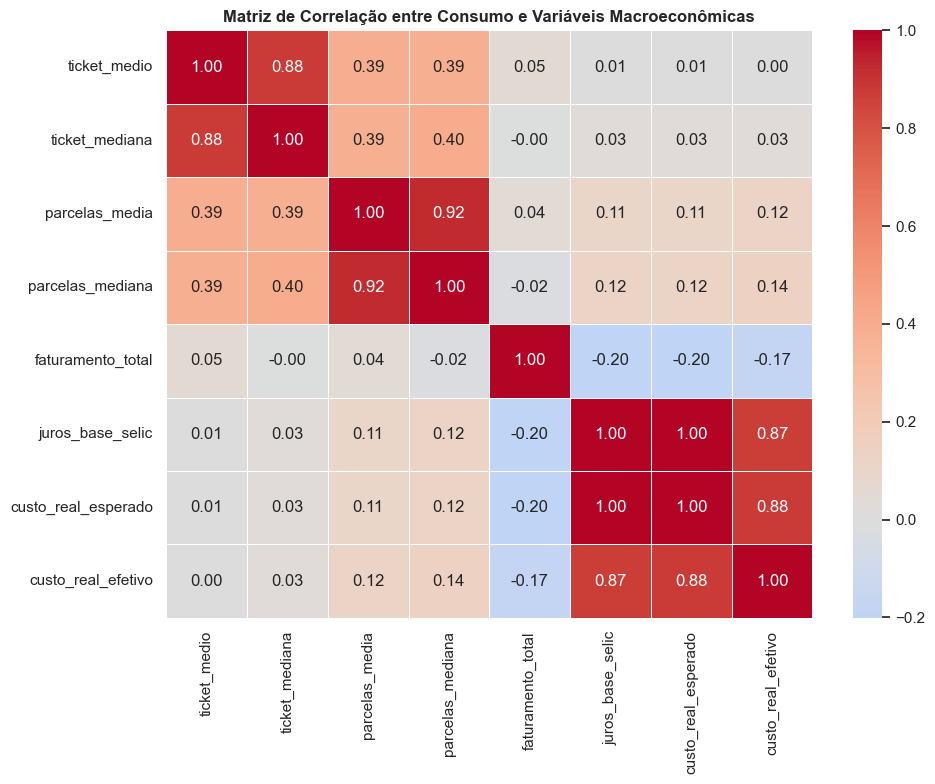

In [21]:
plt.figure(figsize=(10, 8))

sns.heatmap(
    corr_matrix,
    annot=True,
    fmt='.2f',
    cmap='coolwarm',
    center=0,
    linewidths=0.5
)

plt.title('Matriz de Correlação entre Consumo e Variáveis Macroeconômicas')
plt.tight_layout()
plt.show()


Valores próximos de:

- **+1** indicam correlação positiva forte
- **0** indicam ausência de correlação linear
- **−1** indicam correlação negativa forte

Correlação negativa entre juros e valor do pedido sugere
sensibilidade do consumo ao custo do crédito.

Correlação positiva entre juros e número de parcelas pode indicar
estratégias de suavização do pagamento por parte do consumidor.
